In [18]:
# hide
%reload_ext autoreload
%autoreload 2

In [184]:
import random

import numpy as np
import pandas as pd
import torch
from clientClass import Client
from dataFunction import *
from HE_functions import *
import tenseal as ts
from cryptotree.preprocessing import Featurizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
RANDOM_STATE = 123
from collections import OrderedDict
from base64 import b64encode, b64decode
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from functools import reduce

In [167]:
    # for (poly_mod, coeff_mod_bit_sizes) in [
    #     (8192, [40, 21, 21, 21, 21, 21, 21, 40]),
    #     (8192, [40, 20, 40]),
    #     (8192, [20, 20, 20]),
    #     (8192, [17, 17]),
    #     (4096, [40, 20, 40]),
    #     (4096, [30, 20, 30]),
    #     (4096, [20, 20, 20]),
    #     (4096, [19, 19, 19]),
    #     (4096, [18, 18, 18]),
    #     (4096, [18, 18]),
    #     (4096, [17, 17]),
    #     (2048, [20, 20]),
    #     (2048, [18, 18]),
    #     (2048, [16, 16]),

poly_mod = 2048 
coeff_mod_bit_sizes = [16, 16] 
enc_type = ts.ENCRYPTION_TYPE.ASYMMETRIC #ts.ENCRYPTION_TYPE.SYMMETRIC

context = ts.context(
            scheme=ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=poly_mod,
            plain_modulus=786433,
            coeff_mod_bit_sizes=coeff_mod_bit_sizes,
            encryption_type=enc_type,
        )
context.generate_galois_keys()
# context.serialize()

        

# Make Dataframes for every dataset

In [168]:

cleveland = "FL_HE_2/processed.cleveland.data"
switzerland = "FL_HE_2/processed.switzerland.data"
va = "FL_HE_2/processed.va.data"
hungarian = "FL_HE_2/reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)
df_dict ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }



In [169]:
torch.random.manual_seed(73)
random.seed(73)
n_clients = 4
clients = []
for i in list(df_dict.keys()):
    df = df_dict.get(i)
    df_dict[i] = new_df(df)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")
    cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
    location_data = make_dummies(location_data, cat_feat)
    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Cholesterol', 'Oldpeak']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    # keys = context.generate_galois_keys()
    clients.append(Client(i, x, y, cat_feat, context))



# Random Forest

In [208]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 10, 
              'min_samples_split': 10,
              'max_features': None,
              'max_depth': 6,
              'max_leaf_nodes': None,
              'random_state':42,
              'oob_score':True}
best_est = {}
rf_trees = []
validation_X_set = []
validation_y_set = []

for client in clients:
    pipe = Featurizer(cat_feat)
    y_train, y_valid, X_train_normalized, X_valid_normalized = split_prep_data(client, pipe)
    RF_model = RandomForestClassifier(**parameters)
    RF_model.fit(X_train_normalized, y_train)
    RF_predictions = RF_model.predict(X_valid_normalized)
    score = accuracy_score(y_valid ,RF_predictions)
    print(client.name)
    print(score)
    rf_trees.append(RF_model)
    if client.name == 'Cleveland':
        validation_X_set = X_valid_normalized
        validation_y_set = y_valid
    else:
        validation_X_set = np.concatenate((validation_X_set, X_valid_normalized), axis=0)
        validation_y_set = np.concatenate((validation_y_set, y_valid), axis=0)



    # feature_list = list(client.X.columns)
    # # Get numerical feature importances
    # importances = list(RF_model.feature_importances_)
    # # List of tuples with variable and importance
    # feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # # Sort the feature importances by most important first
    # feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # # New random forest with only the two most important variables
    # rf_most_important = RandomForestClassifier(**parameters )
    # imp_feat = []
    # important_indices = []
    # for i in range(len(feature_list)):
    #     if feature_importances[i][1] > 0.1:
    #         imp_feat.append(feature_importances[i][0])
    # for j in imp_feat:
    #     important_indices.append(feature_list.index(j))

    # # Extract the two most important features
    # # important_indices = [feature_list.index('ExerciseAngina'), feature_list.index('Oldpeak'), feature_list.index('ChestPainType_3.0')]
    # train_important = X_train_normalized[:, important_indices]
    # test_important = X_valid_normalized[:, important_indices]
    # # Train the random forest
    # # rf = RandomForestClassifier(random_state=42, n_jobs=-1)

    # # Number of trees in random forest
    # n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
    # # Number of features to consider at every split
    # max_features = ['auto', 'sqrt']
    # # Maximum number of levels in tree
    # max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
    # # Minimum number of samples required to split a node
    # # min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
    # min_samples_split = [1.0, 2, 5, 10, 15, 20, 30]
    # # Minimum number of samples required at each leaf node
    # min_samples_leaf = [1, 2, 3, 4]
    # # Method of selecting samples for training each tree
    # bootstrap = [True, False]
    # # Criterion
    # criterion=['gini', 'entropy']
    # random_grid = {'n_estimators': n_estimators,
    # #                'max_features': max_features,
    #            'max_depth': max_depth,
    #            'min_samples_split': min_samples_split,
    #            'min_samples_leaf': min_samples_leaf,
    #            'bootstrap': bootstrap,
    #            'criterion': criterion}
    # rf_base = RandomForestClassifier()
    # rf_random = RandomizedSearchCV(estimator = rf_base,
    #                             param_distributions = random_grid,
    #                             n_iter = 30, cv = 5,
    #                             verbose=0,
    #                             random_state=42, n_jobs = 4, error_score='raise')
    # rf_random.fit(X_train_normalized, y_train)
    # print(rf_random.best_params_)
    # print (rf_random.score(X_train_normalized, y_train))
    # print(rf_random.score(X_valid_normalized, y_valid))
    # best_est[client.name] = rf_random.best_params_

    # param_grid = {
    # 'n_estimators': np.linspace(2100, 2300, 5, dtype = int),
    # 'max_depth': [170, 180, 190, 200, 210, 220],
    # 'min_samples_split': [2, 3, 4],
    # 'min_samples_leaf': [2, 3, 4, 5]
    # }

    # rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = True)
    # # Instantiate the grid search model
    # grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
    #                         cv = 5, n_jobs = 8, verbose = 0, error_score='raise')
    # grid_rf_search.fit(X_train_normalized, y_train)

    # best_rf_grid = grid_rf_search.best_estimator_
    # best_est[i.name] = best_rf_grid
    # print(grid_rf_search.best_params_)
    # print (grid_rf_search.score(X_train_normalized, y_train))
    # print(grid_rf_search.score(X_valid_normalized, y_valid))
    # # Instantiate the grid search model
    # params = {
    # 'max_depth': [2,3,5,10,20],
    # 'min_samples_leaf': [5,10,20,50,100,200],
    # 'n_estimators': [10,25,30,50,100,200]
    # }
    # grid_search = GridSearchCV(estimator=rf,
    #                        param_grid=params,
    #                        cv = 4,
    #                        n_jobs=-1, verbose=1, scoring="accuracy")
    # grid_search.fit(X_train_normalized, y_train)
    # print(grid_search.best_score_)
    # rf_most_important.fit(train_important, y_train)
    # RF_predictions = rf_most_important.predict(test_important)
    # score = accuracy_score(y_valid ,RF_predictions)
    # print(score)

    # cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=1)
    # n_scores = cross_val_score(rf_most_important, client.X, client.y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    # # report performance
    # print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    # print(rf_most_important.oob_score_)
    # print(RF_model.oob_score_)





Cleveland
0.7704918032786885
Switzerland
0.84
VA Long Beach
0.8
Hungary
0.8983050847457628


In [209]:
def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a
rf_combined = reduce(combine_rfs, rf_trees)

In [218]:
rf_agg = (rf_trees[0].estimators_+rf_trees[1].estimators_+rf_trees[2].estimators_+rf_trees[3].estimators_)

In [211]:
predictions = rf_combined.predict(validation_X_set)
score = accuracy_score(validation_y_set ,predictions)
score

0.7828571428571428

In [212]:
predictions = RF_model.predict(validation_X_set)
score = accuracy_score(validation_y_set ,predictions)
score

0.7085714285714285

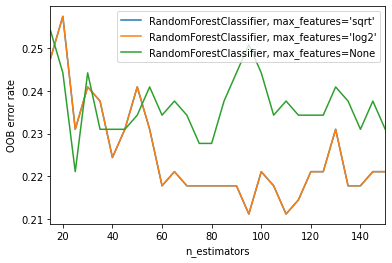

/Users/romyho/Documents/Master_Econometrie/Thesis/Python/thesis_fl/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/romyho/Documents/Master_Econometrie/Thesis/Python/thesis_fl/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/romyho/Documents/Master_Econometrie/Thesis/Python/thesis_fl/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


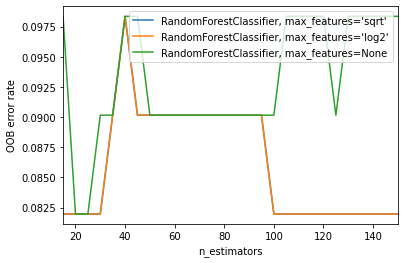

/Users/romyho/Documents/Master_Econometrie/Thesis/Python/thesis_fl/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/romyho/Documents/Master_Econometrie/Thesis/Python/thesis_fl/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/romyho/Documents/Master_Econometrie/Thesis/Python/thesis_fl/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


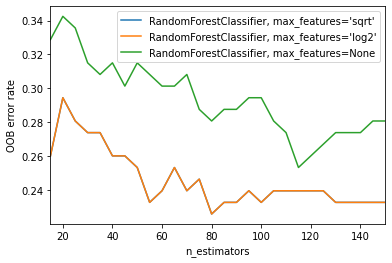

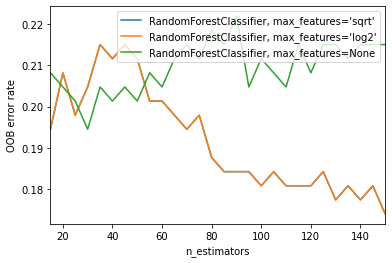

In [135]:

for client in clients:
    ensemble_clfs = [
        (
            "RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(
                warm_start=True,
                oob_score=True,
                max_features="sqrt",
                random_state=RANDOM_STATE,
            ),
        ),
        (
            "RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(
                warm_start=True,
                max_features="log2",
                oob_score=True,
                random_state=RANDOM_STATE,
            ),
        ),
        (
            "RandomForestClassifier, max_features=None",
            RandomForestClassifier(
                warm_start=True,
                max_features=None,
                oob_score=True,
                random_state=RANDOM_STATE,
            ),
        ),
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 15
    max_estimators = 150

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1, 5):
            clf.set_params(n_estimators=i)
            clf.fit(client.X, client.y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

In [108]:
# New random forest with only the two most important variables
rf_most_important = RandomForestClassifier(**parameters )
imp_feat = []
important_indices = []
for i in range(len(feature_list)):
    if feature_importances[i][1] > 0.1:
        imp_feat.append(feature_importances[i][0])
for i in imp_feat:
    important_indices.append(feature_list.index(i))

# Extract the two most important features
# important_indices = [feature_list.index('ExerciseAngina'), feature_list.index('Oldpeak'), feature_list.index('ChestPainType_3.0')]
train_important = X_train_normalized[:, important_indices]
test_important = X_valid_normalized[:, important_indices]
# Train the random forest

RF_model.fit(train_important, y_train)
RF_predictions = RF_model.predict(test_important)
score = accuracy_score(y_valid ,RF_predictions)
print(score)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(RF_model, i.X, i.y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))



0.8813559322033898


AttributeError: 'str' object has no attribute 'X'

# Random forest problems

sample split gives same y values when switzerland dataset is used. Since the heartdisease variable is unevenly divided. 

P(altijd 1) bij 50 subsamples == 2% als verdeling 114 keer 1 en 8 keer 0



P(altijd 1) bij 57 subsamples == 1%

In [107]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(RF_model, clients[3].X, clients[3].y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.823 (0.072)


In [117]:
feature_importances

[('Oldpeak', 0.21),
 ('ExerciseAngina', 0.19),
 ('ChestPainType_4.0', 0.17),
 ('MaxHR', 0.09),
 ('ChestPainType_2.0', 0.08),
 ('Cholesterol', 0.07),
 ('RestingBP', 0.06),
 ('Age', 0.05),
 ('Sex', 0.03),
 ('ChestPainType_3.0', 0.02),
 ('FastingBS', 0.01),
 ('RestingECG_0.0', 0.01),
 ('RestingECG_1.0', 0.01),
 ('ST_Slope_2.0', 0.01),
 ('ST_Slope_1.0', 0.01),
 ('ChestPainType_1.0', 0.0),
 ('RestingECG_2.0', 0.0),
 ('ST_Slope_3.0', 0.0)]